# Setting up

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shap
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.random import set_seed

from preprocessing import load_loan_prepr

# Interpretability measures
from interpretability import PDP, generate_counterfactuals, inverse_transform
from anchor import anchor_tabular
import lime
import lime.lime_tabular

In [ ]:
def find_best_model(model, parameters, X_train, y_train): 
    clf = GridSearchCV(model, parameters, scoring=('balanced_accuracy'), cv=StratifiedKFold())
    clf.fit(X_train, y_train)

    return clf

# Calculates the per-class accuracy given predicted and true output labels.
def class_accs(y_pred, y_true):
    acc0 = ((y_pred == y_true) & (y_true == 0)).sum() / (y_true == 0).sum()
    acc1 = ((y_pred == y_true) & (y_true == 1)).sum() / (y_true == 1).sum()
    return acc0, acc1

# Prints a summary of performance metrics given predicted and true output labels.
def print_metrics(y_pred, y_true):
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    acc0, acc1 = class_accs(y_pred, y_true)
    print(f'F1 = {f1}')
    print(f'Accuracy = {acc}')
    print(f'\tclass 0: {acc0}')
    print(f'\tclass 1: {acc1}')

def classify(output: np.ndarray):
    return (output > 0.5).astype(int)

def print_errors(clf, model_name, X_test, y_test):
    y_pred = clf.predict(X_test)
    if model_name == "neural network":
        y_pred = np.reshape(y_pred, len(y_test))
        y_pred = classify(y_pred)
    
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print("Balanced accuracy ({}) = {}".format(model_name, bal_acc))
    print_metrics(y_pred, y_test)

In [ ]:
X, y, feature_names, categorical = load_loan_prepr()
seed = 3012

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Original shape:  (614, 13)


In [ ]:
print(X.shape)

(480, 11)


    PDP_examples = X_test[[34, 92, 95],:] # [:,[0, 2, 5]]
    print(scaler.inverse_transform(X_test)[:,[0, 2, 5]][[34, 92, 95],:])

    print(feature_names)
    dab = scaler.inverse_transform(X_test)[:,[0, 2, 5]][[34, 92, 95],:]
    print(dab.shape)
    # dab2 = dab[[34, 92, 95],:]
    for i, instance in enumerate(dab):
        print(i, instance)

In [ ]:
# d1 = {"Y": 1, "N": 0}
d2 = {"Yes": 1, "No": 0}
d3 = {"Male": 1, "Female": 0}
d4 = {"0": 0, "1": 1, "2": 2, "3+": 3}
d5 = {"Graduate": 1, "Not Graduate": 0}
d6 = {"Rural": 0, "Semiurban": 0.5, "Urban": 1}

cleanup_nums = {"Married": d2, "Self_Employed": d2, "Gender": d3,
"Dependents": d4, "Education": d5, "Property_Area": d6} # "Loan_Status": d1,

inv_dicts = dict()

# Invert dictionary
for feature, dictionary in cleanup_nums.items():
    inv_dict = {float(v): k for k, v in dictionary.items()}
    inv_dicts[feature] = inv_dict

# Training models

## Scikit-learn models

In [ ]:
model_names = [
    "k-nearest neighbors", 
    "decision tree classifier",
    "support vector classifier",
    ]

parameters = {
    "k-nearest neighbors": {'n_neighbors': np.arange(1, 20), 'weights': ('uniform', 'distance')}, # 'n_neighbors': np.arange(1, 364)
    "decision tree classifier": {'criterion': ('gini', 'entropy'), 'min_samples_split': np.arange(2, 20)}, # 'min_samples_split': np.arange(2, 364)
    "support vector classifier": {'C': np.geomspace(0.01, 100, 41)}
    }

models_init = {
    "k-nearest neighbors": KNeighborsClassifier(),
    "decision tree classifier": DecisionTreeClassifier(random_state=seed),
    "support vector classifier": SVC(kernel="linear", probability=True)
    }

models = dict()
train_times = dict()

for model_name in model_names:
    start = time.time()
    clf = find_best_model(models_init[model_name], parameters[model_name], X_train, y_train)
    end = time.time()
    
    models[model_name] = clf.best_estimator_
    train_times[model_name] = (end - start)

## Neural network

In [ ]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train)

In [ ]:
# Initialise neural network
BATCH_SIZE= 64
INPUT_SIZE= X_train_nn.shape[1]

set_seed(seed)

start = time.time()
model = Sequential()
model.add(Input(INPUT_SIZE))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.1))
# model.add(Dense(5, activation="relu"))
# model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam',
                loss="binary_crossentropy",
                metrics='binary_accuracy')

n_epochs = 101
# n_epochs = 86
history = model.fit(X_train_nn, y_train_nn, batch_size=BATCH_SIZE, epochs=n_epochs, validation_data=(X_val_nn, y_val_nn))
end = time.time()

train_times["neural network"] = (end - start)
models["neural network"] = model

Epoch 1/101
5/5 [==============================] - 3s 518ms/step - loss: 0.7054 - binary_accuracy: 0.6371 - val_loss: 0.7428 - val_binary_accuracy: 0.5844
Epoch 2/101
5/5 [==============================] - 0s 26ms/step - loss: 0.7073 - binary_accuracy: 0.6186 - val_loss: 0.7328 - val_binary_accuracy: 0.5974
Epoch 3/101
5/5 [==============================] - 0s 20ms/step - loss: 0.6822 - binary_accuracy: 0.6453 - val_loss: 0.7236 - val_binary_accuracy: 0.6234
Epoch 4/101
5/5 [==============================] - 0s 25ms/step - loss: 0.7061 - binary_accuracy: 0.6106 - val_loss: 0.7147 - val_binary_accuracy: 0.6494
Epoch 5/101
5/5 [==============================] - 0s 28ms/step - loss: 0.6823 - binary_accuracy: 0.6677 - val_loss: 0.7063 - val_binary_accuracy: 0.6494
Epoch 6/101
5/5 [==============================] - 0s 25ms/step - loss: 0.6730 - binary_accuracy: 0.6918 - val_loss: 0.6980 - val_binary_accuracy: 0.6494
Epoch 7/101
5/5 [==============================] - 0s 21ms/step - loss: 0.6

## Errors and times

In [ ]:
for name, model_time in train_times.items():
    print(f"Model {name} took {model_time} seconds to train")

Model k-nearest neighbors took 1.9175200462341309 seconds to train
Model decision tree classifier took 1.1125001907348633 seconds to train
Model support vector classifier took 20.264036655426025 seconds to train
Model neural network took 16.954256057739258 seconds to train


In [ ]:
for model_name in models.keys():
    print_errors(models[model_name], model_name, X_test, y_test)

Balanced accuracy (k-nearest neighbors) = 0.7181818181818183
F1 = 0.8767123287671234
Accuracy = 0.8125
	class 0: 0.4666666666666667
	class 1: 0.9696969696969697
Balanced accuracy (decision tree classifier) = 0.6681818181818182
F1 = 0.7969924812030075
Accuracy = 0.71875
	class 0: 0.5333333333333333
	class 1: 0.803030303030303
Balanced accuracy (support vector classifier) = 0.7333333333333334
F1 = 0.8918918918918919
Accuracy = 0.8333333333333334
	class 0: 0.4666666666666667
	class 1: 1.0
Balanced accuracy (neural network) = 0.7348484848484849
F1 = 0.8827586206896552
Accuracy = 0.8229166666666666
	class 0: 0.5
	class 1: 0.9696969696969697


In [ ]:
inference_times = dict()

X_copy = np.tile(X_test[:50], (20000, 1))

for model_name, model in models.items():
    start = time.time()
    y_pred = model.predict(X_copy)
    end = time.time()
    inference_times[model_name] = (end - start)

for model_name, inference_time in inference_times.items():
    print(f"Model {model_name} took {inference_time} seconds to make 1 000 000 predictions")

Model k-nearest neighbors took 90.35485339164734 seconds to make 1 000 000 predictions
Model decision tree classifier took 0.08821630477905273 seconds to make 1 000 000 predictions
Model support vector classifier took 12.636113166809082 seconds to make 1 000 000 predictions
Model neural network took 56.84111762046814 seconds to make 1 000 000 predictions


# Intrinsic interpretability

In [ ]:
dtr_feat_imps = models["decision tree classifier"].feature_importances_

svc_coefs = models["support vector classifier"].coef_[0]
svc_feat_imps = np.abs(svc_coefs) / np.sum(np.abs(svc_coefs))

intr_feat_imps = pd.DataFrame({"decision tree classifier": dtr_feat_imps, "support vector classifier": svc_feat_imps}, index=feature_names)
intr_feat_imps.plot.bar()

# plt.show()
plt.tight_layout()
plt.savefig(f"Figures/loan/intrinsic_feature_importance_loan.png", dpi=300)
plt.close()

# Partial dependence plots

In [ ]:
def inverse_transform(X, feat_idx, scaler):
    return X * np.sqrt(scaler.var_[feat_idx]) + scaler.mean_[feat_idx]

In [ ]:
for model_name in models.keys():
    model = models[model_name]
    print(model_name)

    for i in range(len(feature_names)):
        feat_values, PDP_values = PDP("classification", i, feature_names[i], model, X_test, y_test, categorical=categorical[i])
        print(PDP_values)

        # Make a line plot if feature is not categorical and a bar plot if it is categorical
        plt.xlabel(feature_names[i])
        plt.ylabel("Average prediction")

        original_feat_values = inverse_transform(feat_values, i, scaler)

        if not categorical[i]:
            plt.plot(original_feat_values, PDP_values)
        else:
            diff = max(PDP_values) - min(PDP_values)
            if diff != 0.0:
                plt.ylim(max(min(PDP_values) - 0.2 * diff, 0.0), max(PDP_values) + 0.2 * diff)
            else:
                plt.ylim(min(PDP_values) - 0.001, max(PDP_values) + 0.001)
            
            tick_label = original_feat_values

            if feature_names[i] in inv_dicts.keys():
                tick_label = list()
                for value in original_feat_values:
                    tick_label.append(inv_dicts[feature_names[i]][round(value, 2)])

            plt.bar(original_feat_values, PDP_values, width=(original_feat_values[1]-original_feat_values[0]) * 0.9, tick_label=tick_label)

        plt.savefig(f"Figures/loan/PDP_loan_{model_name}_{i}.png", dpi=300)
        plt.close()

k-nearest neighbors
[0.8125, 0.8541666666666666]
[0.8229166666666666, 0.8541666666666666]
[0.84375, 0.84375, 0.8333333333333334, 0.875]
[0.8333333333333334, 0.84375]
[0.8333333333333334, 0.8645833333333334]
[0.8541666666666666, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8229166666666666, 0.8229166666666666, 0.8229166666666666, 0.8229166666666666, 0.8229166666666666, 0.8229166666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8229166666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8229166666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.84375, 0.8541666666666666, 0.8541666666

In [ ]:
for model_name, model in models.items():
    print(model_name, model.predict(PDP_examples))

NameError: name 'PDP_examples' is not defined

Smoother plots if we use probabilities

# SHAP

## Instance-based interpretability

In [ ]:
explainers = dict()

for model_name in models.keys():
  model = models[model_name]

  if model_name == "neural network":
    def nn_predict(X):
      y_pred = model.predict(X)
      y_pred = np.reshape(y_pred, X.shape[0])
      return classify(np.array(y_pred))

    explainers[model_name] = shap.KernelExplainer(nn_predict, shap.kmeans(X_train, 250)) # shap.sample(X_train, 200))
  else:
    explainers[model_name] = shap.KernelExplainer(model.predict, shap.kmeans(X_train, 250)) # shap.sample(X_train, 200))

Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
idx = 4
shap_instance_times = dict()

for model_name in models.keys():
    X_test_df = pd.DataFrame(X_test, columns=feature_names)

    start = time.time()
    explainer = explainers[model_name]
    shap_instance = explainer.shap_values(X_test_df.iloc[idx])
    end = time.time()

    shap_instance_times[model_name] = (end - start)

    # PLOT SHAP VALUES IN NORMAL WAY
    shap_instance = pd.DataFrame(shap_instance, index=feature_names)
    shap_instance.plot.bar(legend=None)
    plt.tight_layout()
    plt.savefig(f"Figures/loan/SHAP_instance_loan_{model_name}_{idx}.png", dpi=300)
    plt.close()

    # shap.initjs()
    # shap.force_plot(explainer.expected_value, shap_instance, X_test_df.iloc[idx])

In [ ]:
for model_name, model_time in shap_instance_times.items():
    print(f"Model {model_name} took {model_time} seconds to explain an instance using SHAP")

Model k-nearest neighbors took 21.39141273498535 seconds to explain an instance using SHAP
Model decision tree classifier took 1.7393653392791748 seconds to explain an instance using SHAP
Model support vector classifier took 4.046915292739868 seconds to explain an instance using SHAP
Model neural network took 12.510249853134155 seconds to explain an instance using SHAP


## Global interpretation

    shap_global_times = dict()
    # X_test_df = pd.DataFrame(X_test, columns=feature_names)

    for model_name in models.keys():
        start = time.time()
        print(model_name)
        explainer = explainers[model_name]

        shap_values = explainer.shap_values(shap.sample(X_test, 50, random_state=seed))
        np.savetxt(f"Output/loan/shap_values_loan_{model_name}.txt", shap_values)
        end = time.time()

        shap_global_times[model_name] = (end - start)

    for name, model_time in shap_global_times.items():
        print(f"Model {name} took {model_time} seconds to explain using SHAP")

In [ ]:
shap_values_all = dict()

for model_name in models.keys():
    shap_values_all[model_name] = np.loadtxt(f"Output/loan/shap_values_loan_{model_name}.txt")

In [ ]:
shap_feat_imps = pd.DataFrame(index=feature_names)

for model_name in models.keys():
  shap_values = shap_values_all[model_name]
  feat_imps = np.mean(np.abs(shap_values), axis=0)
  feat_imps /= np.sum(feat_imps)
  shap_feat_imps.insert(0, model_name, feat_imps)

In [ ]:
shap_feat_imps.plot.bar()
plt.ylabel("SHAP feature importance")
plt.tight_layout()
plt.savefig("Figures/loan/SHAP_feature_importance_loan.png", dpi=300)
plt.close()

# Counterfactuals

In [ ]:
model_name = "decision tree classifier"
model = models[model_name]
print(model.predict(X_test))

[1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1.]


In [ ]:
print(len(X_test))

96


In [ ]:
instance_idx = 92
counterfactual_times = dict()

total_time = 500

for model_name in models.keys():
    instance = X_test[instance_idx]
    model = models[model_name]

    start = time.time()
    counterfactuals, counterfactual_losses = generate_counterfactuals("classification", instance, X_train, model, categorical, seed, total_time=total_time)
    end = time.time()

    counterfactual_times[model_name] = (end - start)

    np.savetxt(f"Output/loan/counterfactuals_loan_{model_name}_instance{instance_idx}.txt", counterfactuals)
    np.savetxt(f"Output/loan/counterfactual_losses_loan_{model_name}_instance{instance_idx}.txt", counterfactual_losses)

Original prediction: 1
100%|██████████| 500/500 [00:03<00:00, 126.13it/s]
Counterfactual_losses: [3.22301208 3.54448806 3.80960617 3.9903475  4.01280051 4.12734369
 4.48784165 4.56073132 4.60985445 4.81334003]
Original prediction: 0
100%|██████████| 500/500 [00:00<00:00, 814.31it/s]
Counterfactual_losses: [0.42666079 0.69884101 0.90983429 1.29399328 1.29815267 1.34503792
 2.00953593 2.29038528 2.33028378 2.50985753]
Original prediction: 1
100%|██████████| 500/500 [00:02<00:00, 216.88it/s]
Counterfactual_losses: [2.83335041 2.8459747  3.78122369 3.80960617 4.12734369 4.90787474
 5.21609806 5.36868054 5.50941082 5.73255787]
Original prediction: 1
100%|██████████| 500/500 [01:25<00:00,  5.82it/s]
Counterfactual_losses: [2.83335041 3.0265135  3.19362863 3.80960617 3.92303279 4.17600609
 4.60985445 4.77126099 4.90787474 5.00990439]


In [ ]:
instance_inv = (scaler.inverse_transform(instance.reshape(1, -1))).reshape(11)

instance_transl = list()

for i, feature_name in enumerate(feature_names):
    if feature_name in inv_dicts.keys():
        instance_transl.append(inv_dicts[feature_name][round(instance_inv[i], 2)])
    else:
        instance_transl.append(instance_inv[i])

print("----- ORIGINAL INSTANCE ------")
print(instance_transl)

counterfactuals_inv = scaler.inverse_transform(counterfactuals)
counterfactuals_transl = list()

for counterfactual in counterfactuals_inv:
    counterfactual_transl = list()
    for i, feature_name in enumerate(feature_names):
        if feature_name in inv_dicts.keys():
            counterfactual_transl.append(inv_dicts[feature_name][round(counterfactual[i], 2)])
        else:
            counterfactual_transl.append(counterfactual[i])
    counterfactuals_transl.append(counterfactual_transl)

print("----- COUNTERFACTUALS -----")
for counterfactual in counterfactuals_transl:
    print(counterfactual)

----- ORIGINAL INSTANCE ------
['Male', 'Yes', '3+', 'Not Graduate', 'Yes', 5703.0, -2.2737367544323206e-13, 130.0, 360.0, 1.0, 'Rural']
----- COUNTERFACTUALS -----
['Male', 'Yes', '3+', 'Not Graduate', 'Yes', 3875.5791802887084, -2.2737367544323206e-13, 130.0, 360.0, 1.0, 'Rural']
['Male', 'Yes', '3+', 'Not Graduate', 'Yes', 5703.0, 1848.554064617396, 130.0, 360.0, 1.0, 'Rural']
['Male', 'Yes', '3+', 'Not Graduate', 'Yes', 5703.0, -2.2737367544323206e-13, 58.23530776703082, 360.0, 1.0, 'Rural']
['Male', 'Yes', '3+', 'Not Graduate', 'Yes', 5703.0, -2.2737367544323206e-13, 130.0, 360.0, 1.0, 'Semiurban']
['Male', 'Yes', '3+', 'Not Graduate', 'Yes', 5703.0, -2.2737367544323206e-13, 130.0, 360.2709697914039, 1.0, 'Semiurban']
['Male', 'Yes', '3+', 'Not Graduate', 'Yes', 5703.0, -2.2737367544323206e-13, 131.6382226856526, 360.0, 1.0, 'Semiurban']
['Male', 'Yes', '3+', 'Not Graduate', 'Yes', 5900.2647599883985, -2.2737367544323206e-13, 130.0, 360.0, 1.0, 'Semiurban']
['Male', 'Yes', '3+', '

In [ ]:
print(counterfactual_losses)

[0.31181245 0.65307852 0.86496687 1.29399328 1.29815267 1.31373848
 1.32765253 1.39731831 1.40648248 1.46771125 1.55230177 1.55678941
 1.67970267 2.08592431 2.12511382 2.27024904 2.27044361 2.29038528
 2.32412023 2.36221704]


In [ ]:
print(model.predict(counterfactuals))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
for model_name, model_time in counterfactual_times.items():
    print(f"Model {model_name} took {model_time} seconds to generate counterfactuals")

Model k-nearest neighbors took 3.974433660507202 seconds to generate counterfactuals
Model decision tree classifier took 0.6183183193206787 seconds to generate counterfactuals
Model support vector classifier took 2.3166310787200928 seconds to generate counterfactuals
Model neural network took 85.98889493942261 seconds to generate counterfactuals


In [ ]:
model_name = "decision tree classifier"

counterfactuals = np.loadtxt(f"Output/loan/counterfactuals_loan_{model_name}_instance{instance_idx}.txt")
counterfactual_losses = np.loadtxt(f"Output/loan/counterfactual_losses_loan_{model_name}_instance{instance_idx}.txt")
instance = X_test[instance_idx]
print(models[model_name].predict(counterfactuals))
print(models[model_name].predict(X_test[:instance_idx+1]))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 0.]


# Anchors

In [ ]:
cat_dict = {0: ["Female", "Male"], 1: ['Not Married', "Married"], 2: ["0","1","2","3+"], 3: ["Not Graduate","Graduate"], 4: ["Not self employed","Self employed"]}
class_names = ['Loan Denied', 'Loan Accepted']
anch_exp = anchor_tabular.AnchorTabularExplainer(
    class_names,
    [ 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
    X_train,
    cat_dict
)
### Anchors do some weird things here depending on the numbers... idx = 27 works great as an example
idx = 27

tmp = X_test[idx].reshape(1, -1)

np.random.seed(seed)

anchor_times = dict()

for name in models.keys():
    print(f"Anchor based on {name} gives: ")
    t =  anch_exp.class_names[int(
        models[name].predict(tmp))]

    start = time.time()

    if name == "neural network":
        def nn_predict(X):
            y_pred = models["neural network"].predict(X)
            y_pred = np.reshape(y_pred, X.shape[0])
            return classify(np.array(y_pred))

        expl = anch_exp.explain_instance(
            X_test[idx],
            nn_predict, threshold=0.6) # Change threshold a bit for more interesting anchors

    else:
        expl = anch_exp.explain_instance(
            X_test[idx],
            models[name].predict) # Change threshold a bit for more interesting anchors

    end = time.time()

    anchor_times[name] = (end - start)

    print('Anchor: %s' % (' AND '.join(expl.names())))
    print('Precision: %.2f' % expl.precision())
    print('Coverage: %.2f' % expl.coverage())


Anchor based on k-nearest neighbors gives: 
Anchor: Loan_Amount_Term <= 0.26 AND CoapplicantIncome <= -0.21 AND Property_Area > -0.05 AND Education = Not Graduate AND Dependents = 0 AND Gender = Female
Precision: 0.97
Coverage: 0.06
Anchor based on decision tree classifier gives: 
Anchor: CoapplicantIncome <= -0.58 AND Education = Not Graduate AND Gender = Female AND Loan_Amount_Term <= 0.26 AND -1.35 < Property_Area <= 1.24 AND Self_Employed = Not self employed AND Credit_History <= 0.41
Precision: 0.78
Coverage: 0.17
Anchor based on support vector classifier gives: 
Anchor: Loan_Amount_Term <= 0.26 AND Education = Not Graduate AND Credit_History <= 0.41 AND Property_Area > -1.35 AND Gender = Female AND LoanAmount <= 0.31 AND CoapplicantIncome <= -0.21
Precision: 0.98
Coverage: 0.16
Anchor based on neural network gives: 
Anchor: 
Precision: 0.83
Coverage: 1.00


In [ ]:
for model_name, model_time in anchor_times.items():
    print(f"Model {model_name} took {model_time} seconds to generate anchor rules")

Model k-nearest neighbors took 0.8756978511810303 seconds to generate anchor rules
Model decision tree classifier took 0.6131925582885742 seconds to generate anchor rules
Model support vector classifier took 0.43254590034484863 seconds to generate anchor rules
Model neural network took 0.11177420616149902 seconds to generate anchor rules


# LIME

## Instance-based interpretability

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, 
    feature_names=[ 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'], 
    class_names=['Loan Denied', 'Loan Accepted'],
    categorical_features=[0, 1, 2, 3, 4, 9, 10], 
    verbose=True, mode='classification')

In [ ]:
np.random.seed(20)
idx = 20
lime_times = dict()

for name in models.keys():
    print(f"Lime explanation for {name}")
    start = time.time()
    if name == "neural network":
        def nn_predict_proba(X):
            y_pred = models[name].predict(X)
            y_prob = np.tile(y_pred, (1, 2))
            y_prob[:,0] = 1.0 - y_prob[:,-1]
            return y_prob
        
        exp = explainer.explain_instance(X_test[idx], nn_predict_proba, num_features=11) 
    else: 
        exp = explainer.explain_instance(X_test[idx], models[name].predict_proba, num_features=11) # Change num_featurese for more or less explainations
    
    exp.show_in_notebook(show_table=True)
    end = time.time()
    lime_times[name] = (end - start)

print(y_test[idx])

In [ ]:
for model_name, model_time in lime_times.items():
    print(f"Model {model_name} took {model_time} seconds to generate an explanation using LIME")

Model k-nearest neighbors took 3.1001031398773193 seconds to generate an explanation using LIME
Model decision tree classifier took 3.2748122215270996 seconds to generate an explanation using LIME
Model support vector classifier took 3.15670108795166 seconds to generate an explanation using LIME
Model neural network took 3.3951752185821533 seconds to generate an explanation using LIME


## Global interpretation

    lime_global_times = dict()
    np.random.seed(seed)

    for model_name in models.keys():
        start = time.time()
        print(model_name)
        lime_values = np.zeros((50, len(feature_names)))

        for idx, instance in enumerate(shap.sample(X_test, 50, random_state=seed)):
        
            if model_name == "neural network":

                def nn_predict_proba(X):
                    y_pred = models[model_name].predict(X)
                    y_prob = np.tile(y_pred, (1, 2))
                    y_prob[:,0] = 1.0 - y_prob[:,-1]
                    return y_prob

                exp = explainer.explain_instance(instance, nn_predict_proba, num_features=11)

            else: 
                exp = explainer.explain_instance(instance, models[model_name].predict_proba, num_features=11)

            exp_dict = exp.as_map()

            for feat_idx, lime_value in exp_dict[1]:
                lime_values[idx, feat_idx] = lime_value

        end = time.time()
        lime_global_times[model_name] = (end - start)
        np.savetxt(f"Output/loan/lime_values_loan_{model_name}.txt", lime_values)
        print("---------------------------------------------------------------")

    for name, model_time in lime_global_times.items():
        print(f"Model {name} took {model_time} seconds to explain using LIME")

In [ ]:
lime_values_all = dict()

for model_name in models.keys():
    lime_values_all[model_name] = np.loadtxt(f"Output/loan/lime_values_loan_{model_name}.txt")

In [ ]:
lime_feat_imps = pd.DataFrame(index=feature_names)

for model_name in models.keys():
  lime_values = lime_values_all[model_name]
  feat_imps = np.mean(np.abs(lime_values), axis=0)
  feat_imps /= np.sum(feat_imps)
  lime_feat_imps.insert(0, model_name, feat_imps)

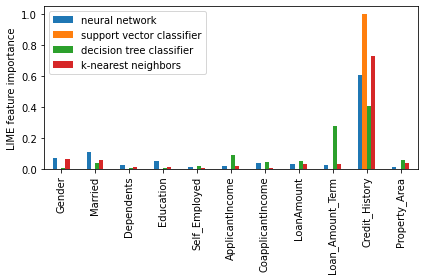

In [ ]:
lime_feat_imps.plot.bar()
plt.ylabel("LIME feature importance")
plt.tight_layout()
plt.savefig("Figures/loan/LIME_feature_importance_loan.png", dpi=300)
plt.show()
plt.close()

# Comparing feature importances

Lai et al.

    intr_mapper = dict()
    shap_mapper = dict()

    for model_name in models.keys():
        intr_mapper[model_name] = model_name + " (intrinsic)"
        shap_mapper[model_name] = model_name + " (SHAP)"

    intr_feat_imps.rename(columns=intr_mapper, errors="ignore")
    shap_feat_imps.rename(columns=shap_mapper)

    all_feat_imps = pd.concat([intr_feat_imps.rename(columns=intr_mapper, errors="ignore"), shap_feat_imps.rename(columns=shap_mapper)], axis=1)

In [ ]:
intr_mapper = {
    "decision tree classifier": "dtr (intr)", 
    "support vector classifier": "svc (intr)", 
    # "k-nearest neighbors": "knn (intr)", 
    # "neural network": "nn (intr)",
    }

shap_mapper = {
    "decision tree classifier": "dtr (SHAP)", 
    "support vector classifier": "svc (SHAP)", 
    "k-nearest neighbors": "knn (SHAP)", 
    "neural network": "nn (SHAP)",
    }

lime_mapper = {
    "decision tree classifier": "dtr (LIME)", 
    "support vector classifier": "svc (LIME)", 
    "k-nearest neighbors": "knn (LIME)", 
    "neural network": "nn (LIME)",
    }

all_feat_imps = pd.concat([intr_feat_imps.rename(columns=intr_mapper, errors="ignore"), shap_feat_imps.rename(columns=shap_mapper), lime_feat_imps.rename(columns=lime_mapper)], axis=1)

In [ ]:
all_feat_imps_columns = all_feat_imps.columns
jaccard_sim = pd.DataFrame(np.zeros((len(all_feat_imps_columns), len(all_feat_imps_columns))), index=all_feat_imps_columns, columns=all_feat_imps_columns)
jaccard_sims = list()

for k in range(1, len(feature_names) + 1):
    for column_name_1 in all_feat_imps_columns:
        for column_name_2 in all_feat_imps_columns:
            feat_imps_1 = np.array(all_feat_imps[column_name_1])
            feat_imps_2 = np.array(all_feat_imps[column_name_2])

            top_features_1 = feature_names[np.argsort(feat_imps_1)][::-1][:k]
            top_features_2 = feature_names[np.argsort(feat_imps_2)][::-1][:k]

            union = len(top_features_1)
            intersec = 0

            for feature in top_features_1:
                if feature in top_features_2:
                    intersec += 1
                else: 
                    union += 1

            jaccard_sim[column_name_1][column_name_2] = intersec / union

    f, ax = plt.subplots(figsize=(6, 6), dpi=300)
    sns.heatmap(jaccard_sim, vmin=0.0, vmax=1.0, annot=True, square=True)
    plt.tight_layout()
    plt.savefig(f"Figures/loan/jaccard_loan_top_{k}.png")
    plt.show()
    plt.close()

    jaccard_sims.append(jaccard_sim.copy())

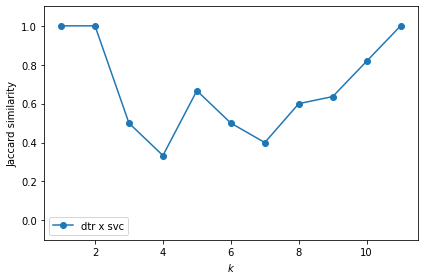

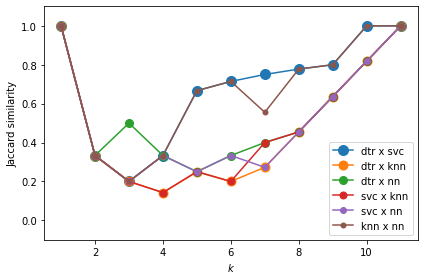

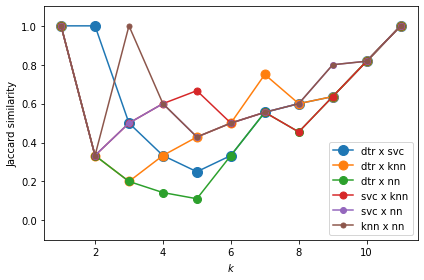

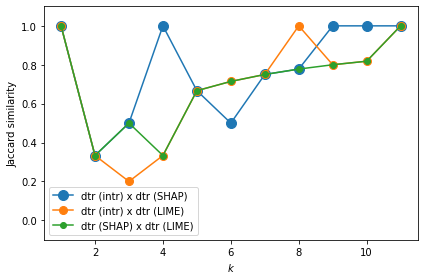

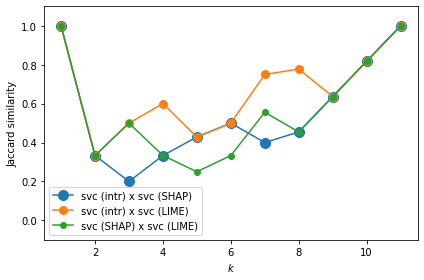

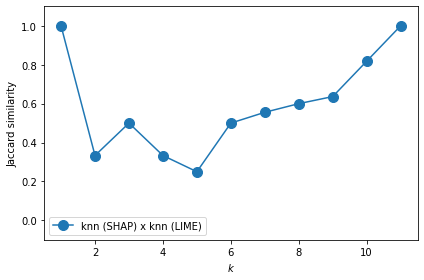

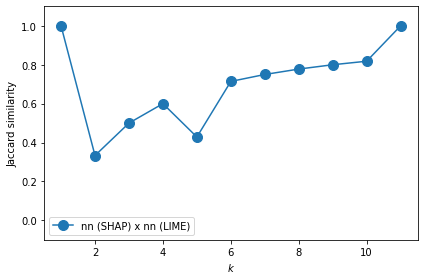

In [ ]:
# Compare intrinsic values
compairs = [("dtr (intr)", "svc (intr)")]

for pair in compairs:
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1[:-7]} x {column_name_2[:-7]}", marker="o")

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/loan/jaccard_intr_models.png", dpi=300)
plt.show()
plt.close()

# Compare SHAP values
compairs = [
    ("dtr (SHAP)", "svc (SHAP)"),
    ("dtr (SHAP)", "knn (SHAP)"),
    ("dtr (SHAP)", "nn (SHAP)"),
    ("svc (SHAP)", "knn (SHAP)"),
    ("svc (SHAP)", "nn (SHAP)"),
    ("knn (SHAP)", "nn (SHAP)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1[:-7]} x {column_name_2[:-7]}", marker="o", markersize=10-1.0*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/loan/jaccard_SHAP_models.png", dpi=300)
plt.show()
plt.close()

# Compare LIME models
compairs = [
    ("dtr (LIME)", "svc (LIME)"),
    ("dtr (LIME)", "knn (LIME)"),
    ("dtr (LIME)", "nn (LIME)"),
    ("svc (LIME)", "knn (LIME)"),
    ("svc (LIME)", "nn (LIME)"),
    ("knn (LIME)", "nn (LIME)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1[:-7]} x {column_name_2[:-7]}", marker="o", markersize=10-1.0*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/loan/jaccard_LIME_models.png", dpi=300)
plt.show()
plt.close()

# Compare decision tree interpretability
compairs = [
    ("dtr (intr)", "dtr (SHAP)"),
    ("dtr (intr)", "dtr (LIME)"),
    ("dtr (SHAP)", "dtr (LIME)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1} x {column_name_2}", marker="o", markersize=10-2*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/loan/jaccard_decision_tree_classifier.png", dpi=300)
plt.show()
plt.close()

# Compare support vector interpretability
compairs = [
    ("svc (intr)", "svc (SHAP)"),
    ("svc (intr)", "svc (LIME)"),
    ("svc (SHAP)", "svc (LIME)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1} x {column_name_2}", marker="o", markersize=10-2*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/loan/jaccard_support_vector_classifier.png", dpi=300)
plt.show()
plt.close()

# Compare kNN interpretability
compairs = [
    ("knn (SHAP)", "knn (LIME)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1} x {column_name_2}", marker="o", markersize=10-2*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/loan/jaccard_k_nearest_neighbors_classifier.png", dpi=300)
plt.show()
plt.close()

# Compare neural network interpretability
compairs = [
    ("nn (SHAP)", "nn (LIME)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1} x {column_name_2}", marker="o", markersize=10-2*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/loan/jaccard_neural_network_classifier.png", dpi=300)
plt.show()
plt.close()

In [ ]:
print(all_feat_imps.columns)

Index(['dtr (intr)', 'svc (intr)', 'nn (SHAP)', 'svc (SHAP)', 'dtr (SHAP)',
       'knn (SHAP)', 'nn (LIME)', 'svc (LIME)', 'dtr (LIME)', 'knn (LIME)'],
      dtype='object')


In [ ]:
print(all_feat_imps[["dtr (intr)", "dtr (SHAP)", "dtr (LIME)"]])

                   dtr (intr)  dtr (SHAP)  dtr (LIME)
Gender               0.000000    0.000000    0.008364
Married              0.018035    0.008420    0.038851
Dependents           0.013345    0.000000    0.007529
Education            0.014331    0.071014    0.007380
Self_Employed        0.037750    0.005650    0.016385
ApplicantIncome      0.135933    0.198784    0.088484
CoapplicantIncome    0.233551    0.118107    0.044782
LoanAmount           0.172140    0.131027    0.050983
Loan_Amount_Term     0.045692    0.010578    0.276025
Credit_History       0.300184    0.374732    0.404868
Property_Area        0.029037    0.081686    0.056349


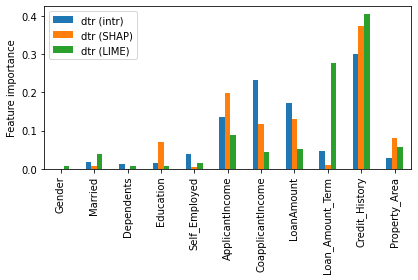

In [ ]:
all_feat_imps[["dtr (intr)", "dtr (SHAP)", "dtr (LIME)"]].plot.bar()
plt.ylabel("Feature importance")
plt.tight_layout()
plt.savefig("Figures/loan/comp_dtr_feature_importance_loan.png", dpi=300)
plt.show()
plt.close()

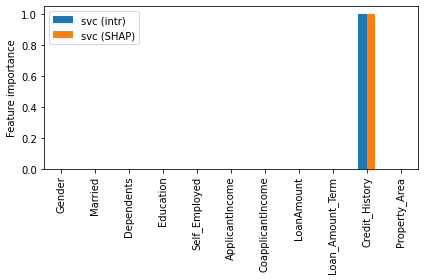

In [ ]:
all_feat_imps[["svc (intr)", "svc (SHAP)"]].plot.bar()
plt.ylabel("Feature importance")
plt.tight_layout()
plt.savefig("Figures/loan/comp_svc_feature_importance_loan.png", dpi=300)
plt.show()
plt.close()

# Prutsen

    for key in history.history.keys():
        plt.plot(np.arange(1, n_epochs+1), history.history[key], label=key)
    plt.legend()
    plt.show()

    print(np.argmin(history.history['val_loss']))
    print(np.where(history.history['val_loss'] == np.min(history.history['val_loss'])))

In [ ]:
model = models["neural network"]
print(np.mean((classify(model.predict(X_test[X_test[:,9] < -2,:]))).flatten()))

0.0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=90a57419-7b7b-4aa4-8a97-858f9f98a849' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>